In [1]:
import tensorflow as tf
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
import pandas as pd
import matplotlib.pyplot as plt
import sys
sys.path.append("..") # Adds higher directory to python modules path.
import os
# os.environ['TF_DETERMINISTIC_OPS'] = '1'
# import random
# seed = 42
# random.seed(seed)
# tf.random.set_seed(seed)
# np.random.seed(seed)

# import brevis
# from brevis import branches
# from brevis import evaluate



import numpy as np
import sys
import os
import pickle
import argparse
import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
import torchvision.transforms as trn
import torchvision.datasets as dset
import torch.nn.functional as F
from skimage.filters import gaussian as gblur
from PIL import Image as PILImage

In [2]:
# Model / data parameters
num_classes = 10
input_shape = (28, 28, 1)
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
print("x_train shape:", x_train.shape)
print(x_train.shape[0], "train samples")
print(x_test.shape[0], "test samples")


# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


In [3]:
# Model / data parameters
num_classes = 10
batch_size = 32
input_shape = (32, 32, 1)
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
print(x_train.shape)
# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test= keras.utils.to_categorical(y_test, num_classes)
    
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train))
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test))
train_ds = (train_ds
                .shuffle(buffer_size=15000,seed=42,reshuffle_each_iteration=False)
                .batch(batch_size=batch_size, drop_remainder=True))

test_ds = (test_ds
                .batch(batch_size=batch_size, drop_remainder=True))
print(train_ds)



(50000, 32, 32, 3)
<BatchDataset element_spec=(TensorSpec(shape=(32, 32, 32, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(32, 10), dtype=tf.float32, name=None))>


In [4]:
# Model / data parameters
num_classes = 100
batch_size = 32
input_shape = (32, 32, 1)
(x_train100, y_train100), (x_test100, y_test100) = tf.keras.datasets.cifar100.load_data(label_mode="fine")
print(x_train100.shape)
# convert class vectors to binary class matrices
y_train100 = keras.utils.to_categorical(y_train100, num_classes)
y_test100 = keras.utils.to_categorical(y_test100, num_classes)
    
train_ds100 = tf.data.Dataset.from_tensor_slices((x_train100, y_train100))
test_ds100 = tf.data.Dataset.from_tensor_slices((x_test100, y_test100))
train_ds100 = (train_ds100
                .shuffle(buffer_size=15000,seed=42,reshuffle_each_iteration=False)
                .batch(batch_size=batch_size, drop_remainder=True))

test_ds100 = (test_ds100
                .batch(batch_size=batch_size, drop_remainder=True))
print(train_ds100)



(50000, 32, 32, 3)
<BatchDataset element_spec=(TensorSpec(shape=(32, 32, 32, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(32, 100), dtype=tf.float32, name=None))>


In [5]:
# # Model / data parameters
# num_classes = 100
# input_shape = (32, 32, 1)
# (x_train100, y_train100), (x_test100, y_test100) = tf.keras.datasets.cifar100.load_data(label_mode="fine")

# # convert class vectors to binary class matrices
# y_train100 = keras.utils.to_categorical(y_train100, num_classes)
# y_test100 = keras.utils.to_categorical(y_test100, num_classes)


In [ ]:
def KL(alpha,K):
    # print("K:",K)
    beta=tf.constant(np.ones((1,K)),dtype=tf.float32)
    S_alpha = tf.reduce_sum(alpha,axis=1,keepdims=True)
    S_beta = tf.reduce_sum(beta,axis=1,keepdims=True)
    lnB = tf.compat.v1.lgamma(S_alpha) - tf.reduce_sum(tf.compat.v1.lgamma(alpha),axis=1,keepdims=True)
    lnB_uni = tf.reduce_sum(tf.compat.v1.lgamma(beta),axis=1,keepdims=True) - tf.compat.v1.lgamma(S_beta)
    
    dg0 = tf.compat.v1.digamma(S_alpha)
    dg1 = tf.compat.v1.digamma(alpha)
    # tf.print("alpha",alpha.shape)
    # tf.print("beta",beta.shape)
    kl = tf.reduce_sum((alpha - beta)*(dg1-dg0),axis=1,keepdims=True) + lnB + lnB_uni
    # print("kl", kl)
    return kl

def _KL(alpha, beta, K ):
    # print("K:",K)
    # beta=tf.constant(np.ones((1,K)),dtype=tf.float32)
    beta = tf.cast(beta,tf.float32)
    alpha = tf.cast(alpha,tf.float32)
    S_alpha = tf.reduce_sum(alpha,keepdims=True)
    S_beta = tf.reduce_sum(beta,keepdims=True)
    lnB = tf.compat.v1.lgamma(S_alpha) - tf.reduce_sum(tf.compat.v1.lgamma(alpha),keepdims=True)
    lnB_uni = tf.reduce_sum(tf.compat.v1.lgamma(beta),keepdims=True) - tf.compat.v1.lgamma(S_beta)
    
    dg0 = tf.compat.v1.digamma(S_alpha)
    dg1 = tf.compat.v1.digamma(alpha)
    # tf.print("alpha",alpha.shape)
    # tf.print("beta",beta.shape)
    kl = tf.reduce_sum((alpha - beta)*(dg1-dg0),keepdims=True) + lnB + lnB_uni
    # print("kl", kl)
    return kl

class lambda_update(tf.keras.callbacks.Callback):
    def __init__(self, annealing_max,  lambda_t=0, max_t=1):
        self.lambda_t = tf.Variable(initial_value=lambda_t, dtype=tf.float32)
        self.max_t = tf.Variable(initial_value=max_t, dtype=tf.float32)
        self.annealing_max = tf.Variable(initial_value=annealing_max, dtype=tf.float32)

    def on_epoch_begin(self, epoch, logs={}): #needs to be on begin, otherwise the epoch update won't increase the value from 0 to 0.1 till the 3rd epoch...
        val = tf.reduce_min([self.max_t, tf.cast(epoch, tf.dtypes.float32) / tf.cast(self.annealing_max, tf.dtypes.float32)])
        tf.print("annealing coef updated to:", val)
        self.lambda_t.assign(val)


def exp_evidence(logits): 
    return tf.exp(tf.clip_by_value(logits/10,-10,10))

def loss_wrapper(lambda_callback: lambda_update):
    def custom_loss_function(p, logits):
    #     squared_difference = tf.square(y_true - y_pred)
    #     return tf.reduce_mean(squared_difference, axis=-1)
    #     alpha = alpha + 1
        evidence = exp_evidence(logits)
        alpha = evidence + 1

        S = tf.reduce_sum(alpha,axis=1,keepdims=True) 
        E = alpha - 1
        m = alpha / S
        A = tf.reduce_sum((p-m)**2, axis=1, keepdims=True) 
        B = tf.reduce_sum(alpha*(S-alpha)/(S*S*(S+1)), axis=1, keepdims=True) 
        # tf.print(annealing_coef)
        # annealing_coef = 
        annealing_coef =  lambda_callback.lambda_t
        alp = E*(1-p) + 1 
        C =   annealing_coef * KL(alp,10)
        return (A + B) + C
    return custom_loss_function




NameError: name 'tf' is not defined

In [7]:
# model = tf.keras.models.Sequential()
# from keras import layers
# model.add(keras.Input(shape=(32,32,3)))
# model.add(layers.Conv2D(32, 5, activation='tanh'))
# model.add(layers.AveragePooling2D(2))
# model.add(layers.Activation('sigmoid'))
# model.add(layers.Conv2D(192, 5, activation='tanh'))
# model.add(layers.AveragePooling2D(2))
# model.add(layers.Activation('sigmoid'))
# model.add(layers.Conv2D(192, 5, activation='tanh'))
# model.add(layers.Flatten())
# model.add(layers.Dense(1000, activation='tanh'))
# model.add(layers.Dense(10, activation='softmax'))
def MAEBM():
    def loss(labels, outputs):
        evidence =exp_evidence(outputs) #activation function
        # evidence = exp_evidence(outputs)
        # alpha = evidence + 1
        alpha = evidence + 1
        S = tf.reduce_sum(alpha)
        # tf.print(S)
        alpha_0 = tf.fill(alpha.shape,S)
        # tf.print(alpha)
        UCE_loss = tf.reduce_mean(labels * (tf.compat.v1.digamma(alpha_0) - tf.compat.v1.digamma(alpha)))
        UCE_loss  +=  0.0001  * (tf.reduce_sum(tf.compat.v1.lgamma(alpha)) - tf.compat.v1.lgamma(S) -
                (len(alpha) - S) * tf.compat.v1.digamma(S) -
                ((alpha - 1.0) * tf.reduce_sum(tf.compat.v1.digamma(alpha))))
        # tf.print(UCE_loss)
        return UCE_loss
    return loss 

def entropyMetric():
    def entropy(p, logits):
        #METRIC OF THE mean of uncertainity
        evidence =exp_evidence(logits)
        alpha = evidence +1
        S = tf.reduce_sum(alpha)
        Mass = alpha / S
        u = num_classes / S
        return (tf.reduce_mean(u)) # Note the `axis=-1`
    return entropy

def entropyMetric():
    def entropy(p, logits):
        #METRIC OF THE mean of uncertainity
        evidence =exp_evidence(logits)
        alpha = evidence +1
        S = tf.reduce_sum(alpha)
        Mass = alpha / S
        u = num_classes / S
        return (tf.reduce_mean(u)) # Note the `axis=-1`
    return entropy



def exp_evidence(logits): 
    return tf.exp(tf.clip_by_value(logits/10,-10,10))

def CE(lambda_callback: lambda_update):
    #create a wrapper function that returns a function
    def cross_entropy_evidence(labels, outputs): 
        softmax = tf.nn.softmax(outputs)
        
        evidence = exp_evidence(outputs)
        alpha = evidence + 1
        S = tf.reduce_sum(alpha, axis=1, keepdims=True) 
        E = alpha - 1
        m = alpha / S
        A = tf.reduce_sum(labels * (tf.compat.v1.digamma(S) - tf.compat.v1.digamma(alpha)), axis=1, keepdims=True)
        alp = E*(1-labels) + 1 
        loss = tf.keras.losses.categorical_crossentropy(labels,softmax)
        annealing_rate =  lambda_callback.lambda_t
        beta=tf.constant(np.ones((1,10)),dtype=tf.float32)
        
        C =  annealing_rate * KL(alp,10)
        #A = annealing_rate * A
        return loss #+ A +  C
        # return (A + B) + C
    return  cross_entropy_evidence




In [ ]:

lambda_callback = lambda_update(100)
loss = CE(lambda_callback)
model = keras.models.load_model("./models/cifaroutlier_blank.hdf5")
model.compile(optimizer='adam',
              loss=CE(lambda_callback),
              metrics=['accuracy',entropyMetric()])

history = model.fit(train_ds, epochs=10,callbacks=[lambda_callback])

NameError: name 'lambda_update' is not defined

In [15]:
model.save('./models/cifaroutlier_CE_an100.hdf5')

In [31]:
model.evaluate(test_ds)

312/312 [==============================] - 1s 3ms/step - loss: 1.2210 - accuracy: 0.6340 - entropy: 0.0089


[1.2209749221801758, 0.6340144276618958, 0.008880825713276863]

In [12]:
lambda_callback = lambda_update(100)
# loss = CE(lambda_callback)
model = tf.keras.models.load_model('./models/cifaroutlier_EDL_an100.hdf5',custom_objects={"custom_loss_function":loss_wrapper(lambda_callback),"entropy":entropyMetric()})
model.evaluate(test_ds)

312/312 [==============================] - 4s 3ms/step - loss: 0.5611 - accuracy: 0.6409 - entropy: 1.9647e-04


[0.5611034631729126, 0.6409254670143127, 0.0001964670664165169]

In [13]:
# /////////////// Detection Prelims ///////////////
from scipy.special import logsumexp
ood_num_examples = len(test_ds100) // 5
expected_ap = ood_num_examples / (ood_num_examples + len(test_ds100))

concat = lambda x: np.concatenate(x, axis=0)
to_np = lambda x: x.data.cpu().numpy()
class _args:
    def __init__(self):
        self.test_bs= 200
        self.num_to_avg= 1
        self.validate= True
        self.use_xent= True
        # 'method_name= 'cifar10_allconv_baseline',
        self.layers=40
        self.widen_factor= 2
        self.droprate= 0.3
        self.load= '-l'
        self.ngpu= 1
        self.prefetch= 2
        self.out_as_pos= True 
        self.score= 'MSP'
        self.T= 1.
        self.noise= 0
        self.method_name=["pretrained", "oe_tune"]
        self.data_models=["cifar10_wrn","cifar100_wrn"]
        self.gpu=0
       
args = _args()

def get_ood_scores(input_set, in_dist=False,stopping_point = None):
    _score = []
    _right_score = []
    _wrong_score = []
    print(args.score, "xent", args.use_xent)
    with torch.no_grad():
        # for batch_idx, (data, target) in enumerate(loader):
            # if batch_idx >= ood_num_examples // args.test_bs and in_dist is False:
                # break
        for i, (x,y) in enumerate(input_set):
            if stopping_point and i > stopping_point:
                break
            print("prediction: {} of {}".format(i,len(test_ds)),end='\r')
            predictions = model.predict(x)
            for j, prediction in enumerate(predictions):
                # print(y)
                target = y[j]
                output = model.predict(x)
                output = torch.tensor(prediction)
                # data = data.cuda()

                # output = net(data)

                # print(output)
                smax = to_np(F.softmax(output))
                
                if args.use_xent:
                    _output = to_np(output)
                    _score.append(_output.mean() - logsumexp(_output))
                    # _score.append(to_np((output.mean() - torch.logsumexp(output))))
                else:
                    print("no xent")
                    if args.score == 'energy':
                        _output = to_np(output)
                        _score.append( -(args.T * logsumexp(_output/args.T)))
                        
                        # _score.append(-to_np((args.T*torch.logsumexp(output / args.T))))
                    else: # original MSP and Mahalanobis (but Mahalanobis won't need this returned)
                        _score.append(-np.max(smax))

                if in_dist:
                    preds = np.argmax(smax)
                    # print(target
                    # targets = target.numpy().squeeze()
                    targets = np.argmax(target)
                    # print(preds)
                    # print(targets)
                    right_indices = preds == targets
                    wrong_indices = np.invert(right_indices)
                    # print(right_indices)
                    # print(wrong_indices)
                    if args.use_xent:
                        _right_score.append(to_np((output.mean() - logsumexp(output)))[right_indices])
                        _wrong_score.append(to_np((output.mean() - logsumexp(output)))[wrong_indices])
                    else:
                        _right_score.append(-np.max(smax[right_indices]))
                        _wrong_score.append(-np.max(smax[wrong_indices]))

    if in_dist:
        return (_score).copy(), (_right_score).copy(), (_wrong_score).copy()
    else:
        return (_score)[:ood_num_examples].copy()
    
    
# def remade_ood_scores(input_set, stopping_point=None):
#     _score = []
#     _right_score = []
#     _wrong_score = []
#     print(args.T)
#     for i, (x,y) in enumerate(input_set):
#         if stopping_point and i > stopping_point:
#             break
#         print("prediction: {} of {}".format(i,len(test_ds)),end='\r')
#         predictions = model.predict(x)
#         for j, prediction in enumerate(predictions):
#             # print(y)
#             target = y[j]
#             output = model.predict(x)
#             # output = torch.tensor(prediction)
#             # _output = to_np(output)
#             _score.append( -(args.T * logsumexp(output/args.T)))
#     return _score


def remade_ood_scores(input_set, stopping_point=None):
    _score = []
    _right_score = []
    _wrong_score = []
    
    Uncert = []
    Results = []
    Labels = []
    print(args.T)
    for i, (x,y) in enumerate(input_set):
        if stopping_point and i > stopping_point:
            break
        print("prediction: {} of {}".format(i,len(test_ds)),end='\r')
        predictions = model.predict(x)
        # print(predictions)
        output = model.predict(x)
        # print(output)
        for j, prediction in enumerate(predictions):
            target = y[j]
            _score.append( -(args.T * logsumexp(prediction/args.T)))
            # output = torch.tensor(prediction)
            # _output = to_np(output)
            # Energy.append( -(args.T * logsumexp(output/args.T)))
            evidence =exp_evidence(prediction)
            alpha = evidence +1
            S = sum(alpha)
            E = alpha - 1
            Mass = alpha / S
            u = num_classes / S
            Uncert.append(u.numpy().mean())
            Results.append(np.argmax(prediction))
            Labels.append(np.argmax(y[j]))
    # _uncert = np.array(Uncert)
    results = pd.DataFrame({"energy":_score,"uncert":Uncert, "x":Results, "y":Labels})
    conditions = [results['x'] == results['y'],results['x'] != results['y']]
    choices = [1, 0]
    results['correct'] = np.select(conditions, choices, default=None)
    
    return results

In [14]:
# in_score, right_score, wrong_score = get_ood_scores(test_ds, in_dist=True, stopping_point=1)
# print(in_score)
# num_right = len(right_score)
# num_wrong = len(wrong_score)
# print(num_right)
# print(num_wrong)
# print('Error Rate {:.2f}'.format(100 * num_wrong / (num_wrong + num_right)))

In [15]:
import math
from scipy.special import logsumexp
num_classes=10


def calcEntropy_Tensors2(y_hat):
    #entropy is the sum of y * log(y) for all possible labels.
    #doesn't deal with cases of log(0)
    val = y_hat * tf.math.log(y_hat)/tf.math.log(tf.constant(2, dtype=y_hat.dtype))
    sumEntropies =  tf.reduce_sum(tf.boolean_mask(val,tf.math.is_finite(val)))
    return -sumEntropies


def getPredictions_Energy(model, input_set, stopping_point=None):
    # stopping_point = None
    num_outputs = len(model.outputs) # the number of output layers for the purpose of providing labels
    #     train_ds, test_ds, validation_ds = (dataset)
    Results=[]
    Pred=[]
    Labels =[]
    Uncert = []
    Outputs = pd.DataFrame()
    Energy = []
    Entropy = []
    pAcc=[]
    calibration=[]
    T = 1 ### temperature variable
    for i, (x,y) in enumerate(input_set):
        if stopping_point and i > stopping_point:
            break
        print("prediction: {} of {}".format(i,len(test_ds)),end='\r')
        predictions = model.predict(x)
        for j, prediction in enumerate(predictions):
            evidence =exp_evidence(prediction)
            alpha = evidence +1
            S = sum(alpha)
            E = alpha - 1
            Mass = alpha / S
            u = num_classes / S
            Uncert.append(u.numpy().mean())
            Results.append(np.argmax(prediction))
            Labels.append(np.argmax(y[j]))
            # Energy.append(prediction.mean() -(logsumexp(prediction)))
            Energy.append( -(1 * logsumexp(np.array(prediction)/1)))
            
            Entropy.append(calcEntropy_Tensors2(tf.nn.softmax(prediction)).numpy())
            calibration.append(np.amax(tf.nn.softmax(prediction).numpy()))
    _uncert = np.array(Uncert)
    # print(_uncert)
    print("")
    print("avg entropy",_uncert.mean())
    print("avg energy",np.array(Energy).mean())
    df = pd.DataFrame({"x":Results,"y":Labels,"uncert":Uncert,"energy":Energy,'entropy':Entropy,'calibration':calibration})
    conditions = [df['x'] == df['y'],df['x'] != df['y']]
    choices = [1, 0]
    df['correct'] = np.select(conditions, choices, default=None)
    return df

# Correct = outputs.loc[(outputs['correct'] == True)].groupby("correct")["uncert"].mean().iloc[0]
# Incorrect = outputs.loc[(outputs['correct'] == False)].groupby("correct")["uncert"].mean().iloc[0]
# print("Correct", Correct, "incorrect", Incorrect)
# print("overallAcc", len(outputs.loc[(outputs['correct'] == True)])/len(outputs))



In [16]:
output_ID= getPredictions_Energy(model, test_ds,stopping_point=None)
output_OOD = getPredictions_Energy(model, test_ds100,stopping_point=None)


prediction: 311 of 312
avg entropy 0.43300316
avg energy -35.59758201863709
prediction: 311 of 312
avg entropy 0.6440355
avg energy -13.265087427782605


In [17]:
# # print(remade_ood_scores(test_ds,stopping_point=10).mean())
# output_OOD = getPredictions_Energy(model, test_ds100,stopping_point=None)
# print(output_OOD)
# print(np.array(output_OOD['energy']).mean())

In [18]:
def buildCompareDistribPlot(ID,OOD,metrics=["energy"], threshold=None, legend=["In Distribution","Out of Distribution"]):
        if type(metrics ) is not list:
            metrics = [metrics]
        for i, metric in enumerate(metrics):
            _ = plt.hist(ID[metric].tolist(), bins=10)  # arguments are passed to np.histogram
            _ = plt.hist(OOD[metric].tolist(), bins=10,color="red",alpha=0.5)  # arguments are passed to np.histogram
            # plt.title("Histogram with 'auto' bins")
            plt.title(metric + " outliers")
            plt.legend(legend)
            plt.xlabel("entropy")
            plt.ylabel("frequency")
            plt.show()
            if threshold:
                if type(threshold) is list:
                    if i >= len(threshold): #no threshold in the array so treat as None.
                        continue
                    _threshold = threshold[i]
                else:
                    _threshold = threshold
                if _threshold == "mean":
                    _threshold = np.array(ID[metric]).mean()
                print("OOD accepted with avg ID ",metric," threshold of ",_threshold, ": ", len(OOD.loc[(OOD[metric].tolist() <= _threshold)]), "out of ", len(OOD))
                print("ID accepted with avg ID ",metric," threshold of ",_threshold, ": ", len(ID.loc[(ID[metric] <= _threshold)]), "out of ", len(ID), "with acc of ", len(ID.loc[(ID[metric] <= _threshold) & ID['correct'] == True])/len(ID.loc[(ID[metric] <= _threshold)]))
                print("Overall accuracy of accepted inputs:", len(ID.loc[(ID[metric] <= _threshold) & ID['correct'] == True])/(len(ID.loc[(ID[metric] <= _threshold)])+len(OOD.loc[(OOD[metric] <= _threshold)])))
                Correct = ID.loc[(ID['correct'] == True)]
                # print(len(Correct))
                Incorrect = ID.loc[(ID['correct'] == False)]
                print("overall acc on ID:",len(Correct)/len(ID))

** CE RESULTS ** <hr>

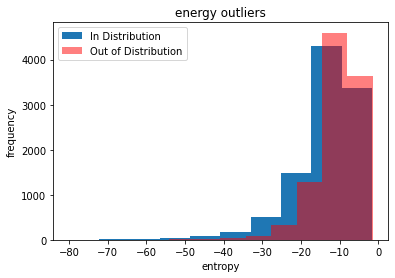

OOD accepted with avg ID  energy  threshold of  -13.7159690573716 :  2088 out of  9984
ID accepted with avg ID  energy  threshold of  -13.7159690573716 :  3762 out of  9984 with acc of  0.7931951089845827
Overall accuracy of accepted inputs: 0.5100854700854701
overall acc on ID: 0.6340144230769231


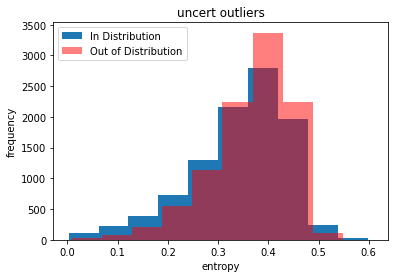

OOD accepted with avg ID  uncert  threshold of  0.3426528 :  3141 out of  9984
ID accepted with avg ID  uncert  threshold of  0.3426528 :  4235 out of  9984 with acc of  0.7353010625737898
Overall accuracy of accepted inputs: 0.42218004338394793
overall acc on ID: 0.6340144230769231


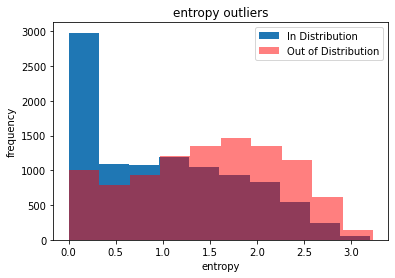

OOD accepted with avg ID  entropy  threshold of  0.9957288 :  2819 out of  9984
ID accepted with avg ID  entropy  threshold of  0.9957288 :  5297 out of  9984 with acc of  0.8131017557107797
Overall accuracy of accepted inputs: 0.5306801379990143
overall acc on ID: 0.6340144230769231


In [36]:

energy_threshold = np.array(output_ID['energy']).mean()#+ output_ID['energy'].std()
edl_threshold = output_ID['uncert'].mean() #+ output_ID['uncert'].std()
entropy_threshold = output_ID['entropy'].mean() #+ output_ID['entropy'].std()

buildCompareDistribPlot(output_ID, output_OOD, ["energy",'uncert','entropy'], "mean")

** EDL Results ** <hr>

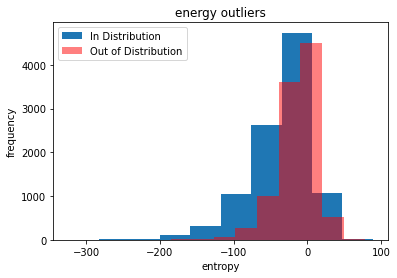

OOD accepted with avg ID  energy  threshold of  -35.59758223476894 :  1555 out of  9984
ID accepted with avg ID  energy  threshold of  -35.59758223476894 :  4079 out of  9984 with acc of  0.883304731551851
Overall accuracy of accepted inputs: 0.6395101171458999
overall acc on ID: 0.6409254807692307


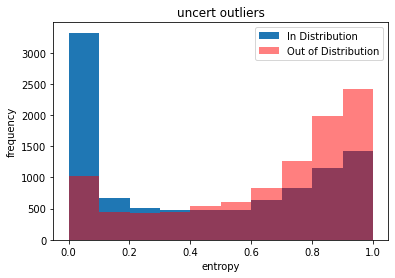

OOD accepted with avg ID  uncert  threshold of  0.43300316 :  2524 out of  9984
ID accepted with avg ID  uncert  threshold of  0.43300316 :  5139 out of  9984 with acc of  0.8355711227865343
Overall accuracy of accepted inputs: 0.5603549523685241
overall acc on ID: 0.6409254807692307


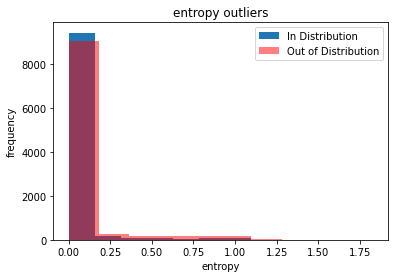

OOD accepted with avg ID  entropy  threshold of  0.036932737 :  8556 out of  9984
ID accepted with avg ID  entropy  threshold of  0.036932737 :  9161 out of  9984 with acc of  0.67066914092348
Overall accuracy of accepted inputs: 0.34678557317830333
overall acc on ID: 0.6409254807692307


In [21]:


energy_threshold = np.array(output_ID['energy']).mean()#+ output_ID['energy'].std()
edl_threshold = output_ID['uncert'].mean() #+ output_ID['uncert'].std()
entropy_threshold = output_ID['entropy'].mean() #+ output_ID['entropy'].std()

buildCompareDistribPlot(output_ID, output_OOD, ["energy",'uncert','entropy'], "mean")
# buildCompareDistribPlot(output_ID, output_OOD, "uncert", edl_threshold)
# buildOutlierPlot_multi(output_ID, output_OOD, "entropy", entropy_threshold)

In [38]:
# print(remade_ood_scores(test_ds,stopping_point=10).mean())
# output = getPredictions_Energy(model, test_ds,stopping_point=None)
output = output_ID
Correct = output.loc[output['correct']==True]
Incorrect = output.loc[output['correct']==False]
print(len(Correct))
print(len(Incorrect))


6330
3654


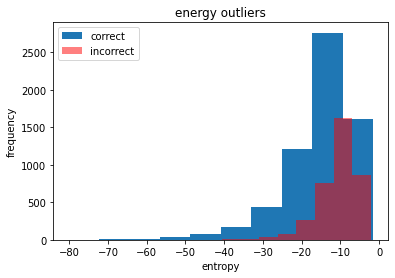

OOD accepted with avg ID  energy  threshold of  -15.44441713751963 :  523 out of  3654
ID accepted with avg ID  energy  threshold of  -15.44441713751963 :  2463 out of  6330 with acc of  1.0
Overall accuracy of accepted inputs: 0.8248492967180174
overall acc on ID: 1.0


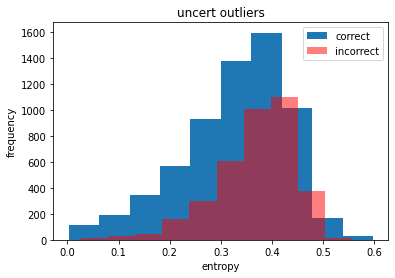

OOD accepted with avg ID  uncert  threshold of  0.32769838 :  929 out of  3654
ID accepted with avg ID  uncert  threshold of  0.32769838 :  2762 out of  6330 with acc of  1.0
Overall accuracy of accepted inputs: 0.7483066919534002
overall acc on ID: 1.0


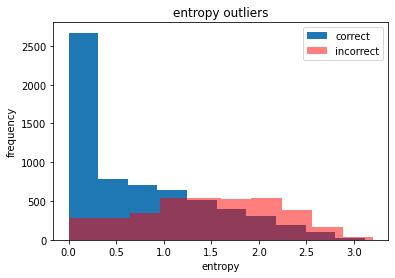

OOD accepted with avg ID  entropy  threshold of  0.72378 :  638 out of  3654
ID accepted with avg ID  entropy  threshold of  0.72378 :  3695 out of  6330 with acc of  1.0
Overall accuracy of accepted inputs: 0.8527579044541888
overall acc on ID: 1.0


In [39]:
### CE

### ID, correct vs incorrect distributions.
buildCompareDistribPlot(Correct, Incorrect, ["energy",'uncert','entropy'], "mean",legend=["correct","incorrect"])

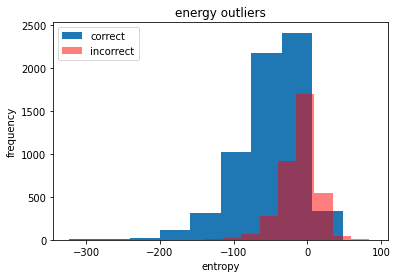

OOD accepted with avg ID  energy  threshold of  -49.36437512047334 :  219 out of  3585
ID accepted with avg ID  energy  threshold of  -49.36437512047334 :  2729 out of  6399 with acc of  1.0
Overall accuracy of accepted inputs: 0.9257123473541384
overall acc on ID: 1.0


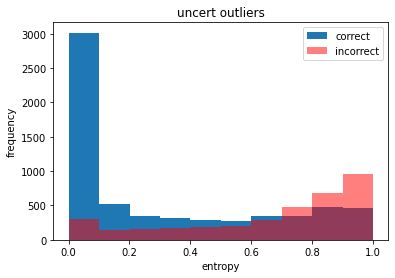

OOD accepted with avg ID  uncert  threshold of  0.30378383 :  616 out of  3585
ID accepted with avg ID  uncert  threshold of  0.30378383 :  3891 out of  6399 with acc of  1.0
Overall accuracy of accepted inputs: 0.8633237186598625
overall acc on ID: 1.0


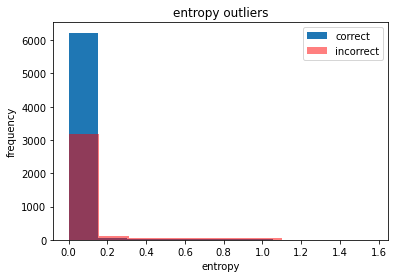

OOD accepted with avg ID  entropy  threshold of  0.01742948 :  2923 out of  3585
ID accepted with avg ID  entropy  threshold of  0.01742948 :  6097 out of  6399 with acc of  1.0
Overall accuracy of accepted inputs: 0.6759423503325942
overall acc on ID: 1.0


In [19]:
### EDL

### ID, correct vs incorrect distributions.
buildCompareDistribPlot(Correct, Incorrect, ["energy",'uncert','entropy'], "mean",legend=["correct","incorrect"])

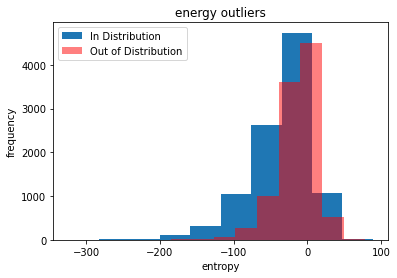

OOD accepted with avg ID  energy  threshold of  -35.59758201863709 :  1555 out of  9984
ID accepted with avg ID  energy  threshold of  -35.59758201863709 :  4079 out of  9984 with acc of  0.883304731551851
Overall accuracy of accepted inputs: 0.6395101171458999
overall acc on ID: 0.6409254807692307


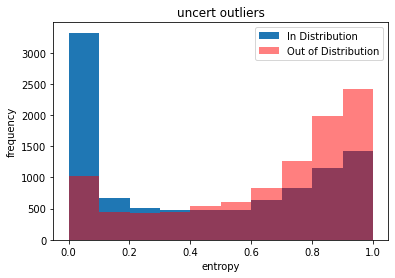

OOD accepted with avg ID  uncert  threshold of  0.43300316 :  2524 out of  9984
ID accepted with avg ID  uncert  threshold of  0.43300316 :  5139 out of  9984 with acc of  0.8355711227865343
Overall accuracy of accepted inputs: 0.5603549523685241
overall acc on ID: 0.6409254807692307


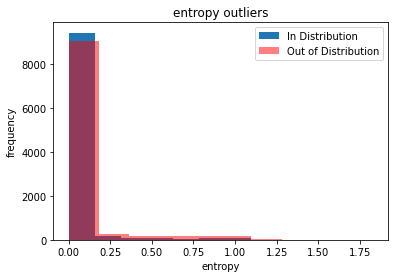

OOD accepted with avg ID  entropy  threshold of  0.036932714 :  8556 out of  9984
ID accepted with avg ID  entropy  threshold of  0.036932714 :  9161 out of  9984 with acc of  0.67066914092348
Overall accuracy of accepted inputs: 0.34678557317830333
overall acc on ID: 0.6409254807692307


In [16]:
def buildCompareDistribPlot_increasing(ID,OOD,metrics=["energy"], threshold=None, legend=["In Distribution","Out of Distribution"]):
        if type(metrics ) is not list:
                metrics = [metrics]
        for i, metric in enumerate(metrics):
            _ = plt.hist(ID[metric].tolist(), bins=10)  # arguments are passed to np.histogram
            _ = plt.hist(OOD[metric].tolist(), bins=10,color="red",alpha=0.5)  # arguments are passed to np.histogram
            # plt.title("Histogram with 'auto' bins")
            plt.title(metric + " outliers")
            plt.legend(legend)
            plt.xlabel("entropy")
            plt.ylabel("frequency")
            plt.show()
            if threshold:
                if type(threshold) is list:
                    if i >= len(threshold): #no threshold in the array so treat as None.
                        continue
                    _threshold = threshold[i]
                else:
                    _threshold = threshold
                if _threshold == "mean":
                    _threshold = np.array(ID[metric]).mean()
                print("OOD accepted with avg ID ",metric," threshold of ",_threshold, ": ", len(OOD.loc[(OOD[metric].tolist() <= _threshold)]), "out of ", len(OOD))
                print("ID accepted with avg ID ",metric," threshold of ",_threshold, ": ", len(ID.loc[(ID[metric] <= _threshold)]), "out of ", len(ID), "with acc of ", len(ID.loc[(ID[metric] <= _threshold) & ID['correct'] == True])/len(ID.loc[(ID[metric] <= _threshold)]))
                Correct = ID.loc[(ID['correct'] == True)]
                Incorrect = ID.loc[(ID['correct'] == False)]
                print("overall acc on ID:",len(Correct)/len(ID))

energy_threshold = np.array(output_ID['energy']).mean()#+ output_ID['energy'].std()
edl_threshold = output_ID['uncert'].mean() #+ output_ID['uncert'].std()
entropy_threshold = output_ID['entropy'].mean() #+ output_ID['entropy'].std()

buildCompareDistribPlot(output_ID, output_OOD, ["energy",'uncert','entropy'], "mean")
# buildCompareDistribPlot(output_ID, output_OOD, "uncert", edl_threshold)
# buildOutlierPlot_multi(output_ID, output_OOD, "entropy", entropy_threshold)

-13.265087624612557


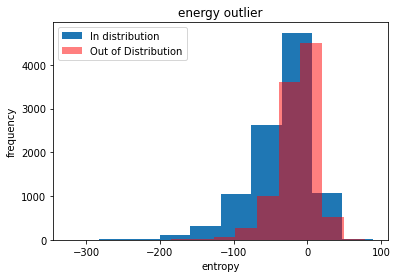

OOD accepted with avg ID entropy threshold of  -13.265087624612557 :  4201 out of  9984
ID accepted with avg ID entropy threshold of  -13.265087624612557 :  6518 out of  9984 with acc of  0.7821417612764652
overall acc on ID: 0.6409254807692307


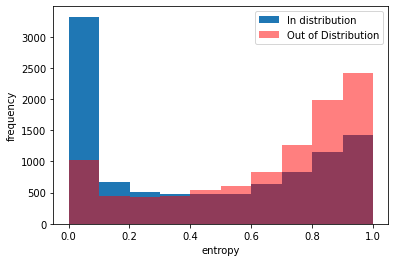

OOD accepted with avg ID entropy threshold of  0.6440355 :  3811 out of  9984
ID accepted with avg ID entropy threshold of  0.6440355 :  6209 out of  9984 with acc of  0.7935255274601385
overall acc on ID: 0.6409254807692307


In [286]:

energy_threshold = np.array(output_OOD['energy']).mean()
print(energy_threshold)
buildOutlierPlot_energy_2(output_ID, output_OOD, energy_threshold)

edl_threshold = output_OOD['uncert'].mean()
buildOutlierPlot(output_ID, output_OOD, edl_threshold)

In [19]:
def buildOutlierPlot_multi(ID,OOD,metrics=["energy"], threshold=None, legend=["In Distribution","Out of Distribution"]):
    # for k in ['confidence_alea_uncert.','entropy_of_expected','expected_entropy','mutual_information','EPKL','differential_entropy']:
        # _ = plt.hist(ID[k].tolist(), bins=10)  # arguments are passed to np.histogram
        # _ = plt.hist(OOD[k].tolist(), bins=10,color="red",alpha=0.5)  # arguments are passed to np.histogram
        plots = []
        points=[]
        if type(metrics ) is not list:
            metrics = [metrics]
            
        for i, metric in enumerate(metrics):
            accuracy = []
            percents = []
            if threshold:
                if type(threshold) is list:
                    if i >= len(threshold): #no threshold in the array so treat as None.
                        continue
                    _threshold = threshold[i]
                else:
                    _threshold = threshold
                if _threshold == "mean":
                    _threshold = np.array(ID[metric]).mean()
                    
            for i in range(11):
                # _OOD = OOD[]
                percent = i / 10
                # print(percent)
                OOD_size = int(len(OOD) * percent)
                _OOD = OOD.head(OOD_size)

                # _ = plt.hist(ID["energy"].tolist(), bins=10)  # arguments are passed to np.histogram
                # _ = plt.hist(_OOD["energy"].tolist(), bins=10,color="red",alpha=0.5)  # arguments are passed to np.histogram
                # plt.title("Histogram with 'auto' bins")
                Correct = (ID.loc[(ID[metric] <= _threshold) & ID['correct'] == True])/len(ID.loc[(ID[metric] <= _threshold)])
                total_inputs = len(ID) + len(_OOD)
                
                # print(len(Correct), len(Correct) / total_inputs)
                
                # Incorrect = ID.loc[(ID['correct'] == False)]
                
                # Correct = ID.loc[(ID['correct'] == True)]
                Incorrect = ID.loc[(ID['correct'] == False)]

                percents.append(percent/2)
                accuracy.append(len(Correct) / total_inputs)
            plots.append(accuracy)
            points.append(percents)



        # title ="{0:.2f}".format(percent)
        # print(plots)
        for i, plot in enumerate(plots):
            plt.plot(points[i],plot,marker = 'o')
        plt.title("outliers")
        plt.legend(metrics)
        plt.xlabel("Outlier percentage")
        plt.ylabel("Accuracy")
        plt.show()

#         print("OOD accepted with avg ID ",metric," threshold of ",_threshold, ": ", len(OOD.loc[(OOD[metric].tolist() <= _threshold)]), "out of ", len(OOD))
#         print("ID accepted with avg ID ",metric," threshold of ",_threshold, ": ", len(ID.loc[(ID[metric] <= _threshold)]), "out of ", len(ID), "with acc of ", len(ID.loc[(ID[metric] <= _threshold) & ID['correct'] == True])/len(ID.loc[(ID[metric] <= _threshold)]))
#         Correct = ID.loc[(ID['correct'] == True)]
#         Incorrect = ID.loc[(ID['correct'] == False)]
#         print("overall acc on ID:",len(Correct)/len(ID))

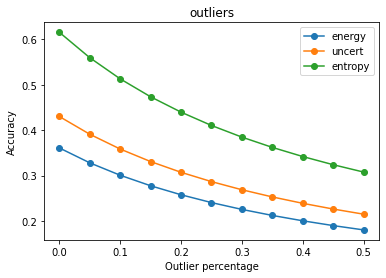

In [20]:
multiplot = buildOutlierPlot_multi(output_ID, output_OOD,metrics=["energy",'uncert','entropy'], threshold="mean")

In [36]:
def buildOutlierPlot_AUC(ID,OOD,metrics=["energy"], threshold=None, legend=["In Distribution","Out of Distribution"]):
    # for k in ['confidence_alea_uncert.','entropy_of_expected','expected_entropy','mutual_information','EPKL','differential_entropy']:
        # _ = plt.hist(ID[k].tolist(), bins=10)  # arguments are passed to np.histogram
        # _ = plt.hist(OOD[k].tolist(), bins=10,color="red",alpha=0.5)  # arguments are passed to np.histogram
        plots = []
        points=[]
        if type(metrics ) is not list:
            metrics = [metrics]
            
        for i, metric in enumerate(metrics):
            accuracy = []
            percents = []
            if threshold:
                if type(threshold) is list:
                    if i >= len(threshold): #no threshold in the array so treat as None.
                        continue
                    _threshold = threshold[i]
                else:
                    _threshold = threshold
                if _threshold == "mean":
                    _threshold = np.array(ID[metric]).mean()
                    
            for i in range(11):
                # _OOD = OOD[]
                percent = i / 10
                # print(percent)
                OOD_size = int(len(OOD) * percent)
                _OOD = OOD.head(OOD_size)

                # _ = plt.hist(ID["energy"].tolist(), bins=10)  # arguments are passed to np.histogram
                # _ = plt.hist(_OOD["energy"].tolist(), bins=10,color="red",alpha=0.5)  # arguments are passed to np.histogram
                # plt.title("Histogram with 'auto' bins")
                Correct = (ID.loc[(ID[metric] <= _threshold) & ID['correct'] == True])/len(ID.loc[(ID[metric] <= _threshold)])
                total_inputs = len(ID) + len(_OOD)
                
                # print(len(Correct), len(Correct) / total_inputs)
                
                # Incorrect = ID.loc[(ID['correct'] == False)]
                
                # Correct = ID.loc[(ID['correct'] == True)]
                Incorrect = ID.loc[(ID['correct'] == False)]
                #x =  false positive / sum(false positive + True Negative)
                # that thresholded are negative, so ID thresh is FN, OOD thresh is TN
                TP =  ID.loc[ID[metric]<=_threshold] #ID that are accepted 
                TN = _OOD.loc[_OOD[metric]>_threshold] #OOD that are not accepted 
                FN =  _OOD.loc[_OOD[metric]<=_threshold] #ID that are accepted 
                FP =  ID.loc[ID[metric]>_threshold] #ID that are accepted 
                
                _TP = len(TP)
                _TN = len(TN)
                _FN = len(FN)
                _FP = len(FP)
                
                # print("TP", len(TP), "TN",len(TN),"FN",len(FN),"FP",len(FP))
                x = _FP/ (_FP + _TN)
                
                y = _TP/(_TP+_FN)
                
                print(x,y)
                percents.append(x)
                accuracy.append(y)
            plots.append(accuracy)
            points.append(percents)



        # title ="{0:.2f}".format(percent)
        # print(plots)
        for i, plot in enumerate(plots):
            plt.plot(points[i],plot,marker = 'o')
        plt.title("AUC OOD")
        plt.legend(legend)
        plt.xlabel("FPR")
        plt.ylabel("TPR")
        plt.show()

#         print("OOD accepted with avg ID ",metric," threshold of ",_threshold, ": ", len(OOD.loc[(OOD[metric].tolist() <= _threshold)]), "out of ", len(OOD))
#         print("ID accepted with avg ID ",metric," threshold of ",_threshold, ": ", len(ID.loc[(ID[metric] <= _threshold)]), "out of ", len(ID), "with acc of ", len(ID.loc[(ID[metric] <= _threshold) & ID['correct'] == True])/len(ID.loc[(ID[metric] <= _threshold)]))
#         Correct = ID.loc[(ID['correct'] == True)]
#         Incorrect = ID.loc[(ID['correct'] == False)]
#         print("overall acc on ID:",len(Correct)/len(ID))

1.0 1.0
0.8737792246226694 0.9656723484848485
0.7777924130663857 0.9295806745670009
0.699893327011971 0.8980625275209159
0.6356297093649085 0.8702794964796245
0.5818307222386442 0.8450383260824529
0.5384825825278132 0.8144968051118211
0.4997461069735951 0.7911171450737006
0.4664296998420221 0.7680286198456034
0.43747221810638615 0.7455675379272528
0.4119575833682154 0.7239971600993965
1.0 1.0
0.8673469387755102 0.9523721275018532
0.7658868163136263 0.9089140431552883
0.6846121237812632 0.8707217892239919
0.618379068283344 0.8366981439270595
0.5639622861133745 0.8048551292090838
0.5199055692670888 0.7722013523666417
0.4803212055120452 0.74640522875817
0.4472858197932053 0.7198487183078862
0.41832153341391815 0.6956816028157574
0.3937423811458757 0.6706250815607464
1.0 1.0
0.849329205366357 0.9149106161989414
0.7421100090171325 0.8427007634992181
0.6495659037095501 0.7821892076502732
0.5857651245551602 0.7286827871460388
0.5323415265200517 0.6821295606850335
0.4852594339622642 0.64161647

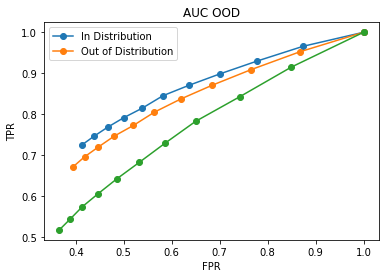

In [37]:
multiplot = buildOutlierPlot_AUC(output_ID, output_OOD,metrics=["energy",'uncert','entropy'], threshold="mean")

In [136]:
output_OOD_edl_100

,x,y,uncert,correct
0,0,49,0.074795,0
1,4,33,0.920631,0
2,4,72,0.631980,0
3,4,51,0.956106,0
4,9,71,0.496918,0
...,...,...,...,...
347,4,7,0.874040,0
348,6,10,0.877300,0
349,6,10,0.816564,0
350,0,68,0.317638,0


In [26]:
### find the optimal threshold between OOD and ID distributions

#combine the sets to find the min and max values for the energy
combined = pd.concat([output_ID,output_OOD])
print(combined)
max_energy = combined['energy'].max()
min_energy = combined['energy'].min()



      x   y    uncert     energy       entropy  calibration correct
0     3   3  0.611689 -18.383732  4.069851e-22      1.000000       1
1     8   8  0.000506 -98.917679 -0.000000e+00      1.000000       1
2     8   8  0.355745 -28.929207  1.759550e-24      1.000000       1
3     0   0  0.020281 -61.801628 -0.000000e+00      1.000000       1
4     6   6  0.859234   0.538187  2.543902e-01      0.957333       1
...  ..  ..       ...        ...           ...           ...     ...
9979  1  27  0.300283 -31.417620  1.202746e-20      1.000000       0
9980  2  30  0.612614 -18.393915  3.585178e-25      1.000000       0
9981  3  52  0.751146  -9.438948  1.814422e-06      1.000000       0
9982  1  74  0.903684   1.034829  3.290858e-10      1.000000       0
9983  6  29  0.224972 -35.289570  1.147606e-18      1.000000       0

[19968 rows x 7 columns]
89.0931396484375 -323.79510498046875


In [22]:

def comparePredictions_Energy(model, input_set, stopping_point=None):
    # stopping_point = None
    num_outputs = len(model.outputs) # the number of output layers for the purpose of providing labels
    #     train_ds, test_ds, validation_ds = (dataset)
    Results=[]
    Pred=[]
    Labels =[]
    Uncert = []
    Outputs = pd.DataFrame()
    Energy = []
    Energy_softmax = []
    Energy_evidence = []
    Energy_alpha = []
    Energy_Mass = []
    Entropy = []
    pAcc=[]
    calibration=[]
    T = 1 ### temperature variable
    for i, (x,y) in enumerate(input_set):
        if stopping_point and i > stopping_point:
            break
        print("prediction: {} of {}".format(i,len(test_ds)),end='\r')
        predictions = model.predict(x)
        for j, prediction in enumerate(predictions):
            evidence =exp_evidence(prediction)
            alpha = evidence +1
            S = sum(alpha)
            E = alpha - 1
            Mass = alpha / S
            u = num_classes / S
            Uncert.append(u.numpy().mean())
            Results.append(np.argmax(prediction))
            Labels.append(np.argmax(y[j]))
            # Energy.append(prediction.mean() -(logsumexp(prediction)))
            Energy.append( -(1 * logsumexp(np.array(prediction)/1)))
            Energy_softmax.append( -(1 * logsumexp(np.array(tf.nn.softmax(prediction))/1)))
            Energy_evidence.append( -(1 * logsumexp(np.array(evidence)/1)))
            Energy_alpha.append( -(1 * logsumexp(np.array(alpha)/1)))
            Energy_Mass.append( -(1 * logsumexp(np.array(Mass)/1)))
            
            
            Entropy.append(calcEntropy_Tensors2(tf.nn.softmax(prediction)).numpy())
            calibration.append(np.amax(tf.nn.softmax(prediction).numpy()))
    _uncert = np.array(Uncert)
    # print(_uncert)
    print("")
    print("avg entropy",_uncert.mean())
    print("avg energy",np.array(Energy).mean())
    df = pd.DataFrame({"x":Results,"y":Labels,"uncert":Uncert,"energy":Energy,"Energy_softmax":Energy_softmax,"Energy_evidence":Energy_evidence,"Energy_alpha":Energy_alpha,"Energy_Mass":Energy_Mass,'entropy':Entropy,'calibration':calibration})
    conditions = [df['x'] == df['y'],df['x'] != df['y']]
    choices = [1, 0]
    df['correct'] = np.select(conditions, choices, default=None)
    return df


In [23]:
output_ID_energy =  comparePredictions_Energy(model, test_ds,stopping_point=None)
output_OOD_energy = comparePredictions_Energy(model, test_ds100,stopping_point=None)


prediction: 311 of 312
avg entropy 0.43300316
avg energy -35.59758201863709
prediction: 311 of 312
avg entropy 0.6440355
avg energy -13.265087427782605


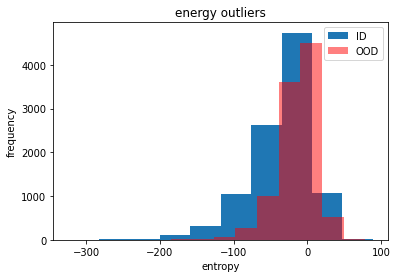

OOD accepted with avg ID  energy  threshold of  -35.59758201863709 :  1555 out of  9984
ID accepted with avg ID  energy  threshold of  -35.59758201863709 :  4079 out of  9984 with acc of  0.883304731551851
Overall accuracy of accepted inputs: 0.6395101171458999
overall acc on ID: 0.6409254807692307


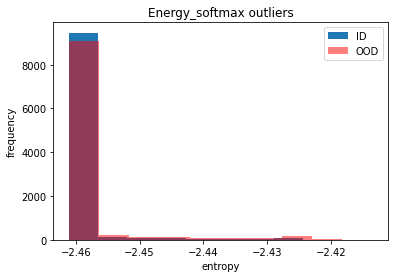

OOD accepted with avg ID  Energy_softmax  threshold of  -2.460042773745954 :  8719 out of  9984
ID accepted with avg ID  Energy_softmax  threshold of  -2.460042773745954 :  9277 out of  9984 with acc of  0.6665948043548561
Overall accuracy of accepted inputs: 0.3436319182040453
overall acc on ID: 0.6409254807692307


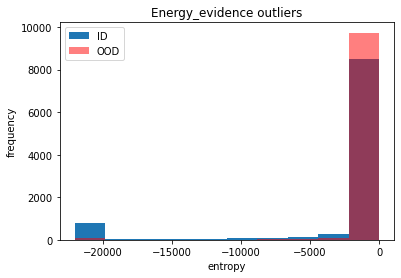

OOD accepted with avg ID  Energy_evidence  threshold of  -2384.261512561295 :  239 out of  9984
ID accepted with avg ID  Energy_evidence  threshold of  -2384.261512561295 :  1457 out of  9984 with acc of  0.9718599862731641
Overall accuracy of accepted inputs: 0.8349056603773585
overall acc on ID: 0.6409254807692307


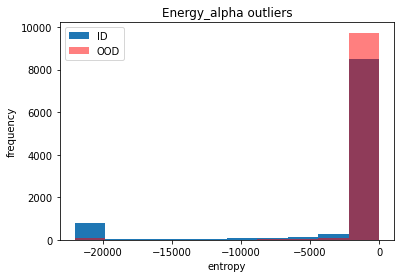

OOD accepted with avg ID  Energy_alpha  threshold of  -2385.2615125646385 :  239 out of  9984
ID accepted with avg ID  Energy_alpha  threshold of  -2385.2615125646385 :  1457 out of  9984 with acc of  0.9718599862731641
Overall accuracy of accepted inputs: 0.8349056603773585
overall acc on ID: 0.6409254807692307


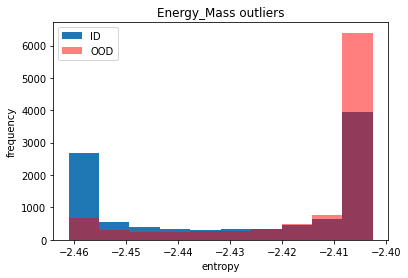

OOD accepted with avg ID  Energy_Mass  threshold of  -2.427978648517567 :  1902 out of  9984
ID accepted with avg ID  Energy_Mass  threshold of  -2.427978648517567 :  4473 out of  9984 with acc of  0.8667560921082048
Overall accuracy of accepted inputs: 0.6081568627450981
overall acc on ID: 0.6409254807692307


In [25]:
buildCompareDistribPlot(output_ID_energy, output_OOD_energy, ["energy",'Energy_softmax','Energy_evidence','Energy_alpha','Energy_Mass'], "mean",legend=["ID","OOD"])

89.0931396484375 -323.79510498046875
1


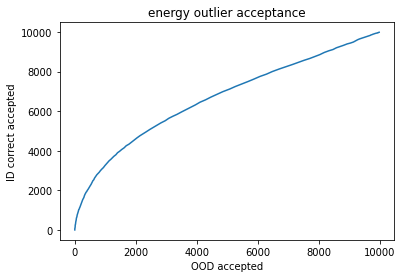

0.9999455 0.00041522982
0.009995303153991698


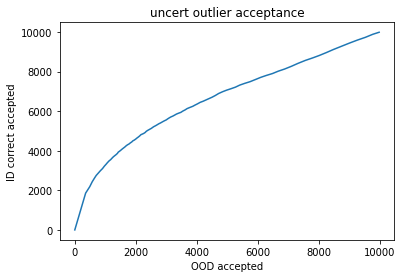

1.8287096 -0.0
0.01828709602355957


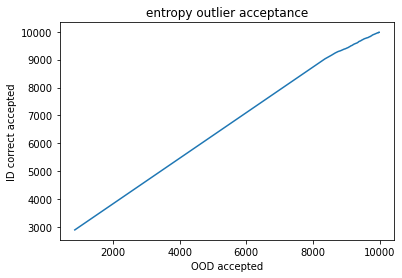

In [121]:
energy_range = range(int(min_energy-1), int(max_energy+1))
metric = "energy"
combined = pd.concat([output_ID,output_OOD])

for metric in ["energy","uncert","entropy"]:

    OOD_accepted= []
    ID_accepted = []
    points =[]
    max_energy = combined[metric].max()
    min_energy = combined[metric].min()
    print(max_energy, min_energy)
    step = min((max_energy - min_energy) /100,1)
    print(step)
    # energy_range = range((min_energy), (max_energy))
    energy_range = np.arange (min_energy, max_energy, step)
    # print(energy_range)
    
    for _threshold in energy_range:

        
        # print(len(output_OOD.loc[output_OOD[metric] <= _threshold]))
        # print(_threshold)
        OOD_accepted.append( len(output_OOD.loc[output_OOD[metric] <= _threshold]))
        # OOD_accepted.append(_threshold)
        # if len(output_ID.loc[(output_ID[metric] <= _threshold)]) > 0:
        # ID_accepted.append( len(output_ID.loc[(output_ID[metric] <= _threshold) & output_ID['correct'] == True]))#/ len(output_ID.loc[(output_ID[metric] <= _threshold)]))
        ID_accepted.append( len(output_ID.loc[(output_ID[metric] <= _threshold) ]))#/ len(output_ID.loc[(output_ID[metric] <= _threshold)]))
        # print(_threshold, len(output_OOD.loc[output_OOD[metric] <= _threshold]),len(output_ID.loc[(output_ID[metric] <= _threshold) ]))
        # if _threshold == 0:
            # points.append([ len(output_OOD.loc[output_OOD[metric] <= _threshold]),len(output_ID.loc[(output_ID[metric] <= _threshold) & output_ID['correct'] == True])])

        # else: 
            # ID_accepted.append(0)
    plt.title(metric + " outlier acceptance")
    plt.plot(OOD_accepted,ID_accepted)
    plt.xlabel("OOD accepted")
    plt.ylabel("ID correct accepted")
    plt.show()


In [50]:
from sklearn.linear_model import LogisticRegression
# all parameters not specified are set to their defaults
logisticRegr = LogisticRegression()

In [77]:
def pdf(x, std, mean):
    const = 1.0 / np.sqrt(2*np.pi*(std**2))
    pdf_normal_dist = const*np.exp(-((x-mean)**2)/(2.0*(std**2)))
    return pdf_normal_dist
x = np.linspace(-200, 100, num=500)
good_pdf = pdf(x,output_ID['energy'].std(),output_ID["energy"].mean())
bad_pdf = pdf(x,output_OOD['energy'].std(),output_OOD["energy"].mean())

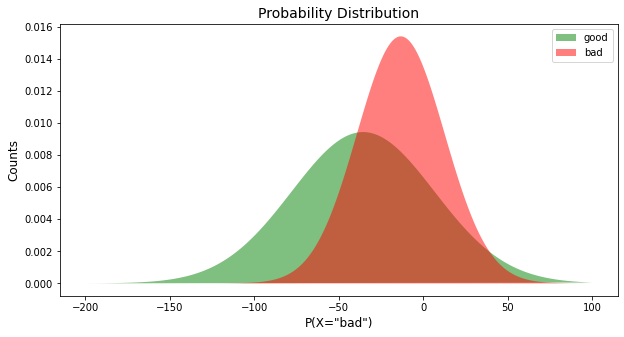

In [85]:
def plot_pdf(good_pdf, bad_pdf, ax):
    ax.fill(x, good_pdf, "g", alpha=0.5)
    ax.fill(x, bad_pdf,"r", alpha=0.5)
    # ax.set_xlim([0,1])
    # ax.set_ylim([0,5])
    ax.set_title("Probability Distribution", fontsize=14)
    ax.set_ylabel('Counts', fontsize=12)
    ax.set_xlabel('P(X="bad")', fontsize=12)
    ax.legend(["good","bad"])

x = np.linspace(-200, 100, num=500)
good_pdf = pdf(x,output_ID['energy'].std(),output_ID["energy"].mean())
bad_pdf = pdf(x,output_OOD['energy'].std(),output_OOD["energy"].mean())
fig, ax = plt.subplots(1,1, figsize=(10,5))
plot_pdf(good_pdf, bad_pdf, ax)
    

    

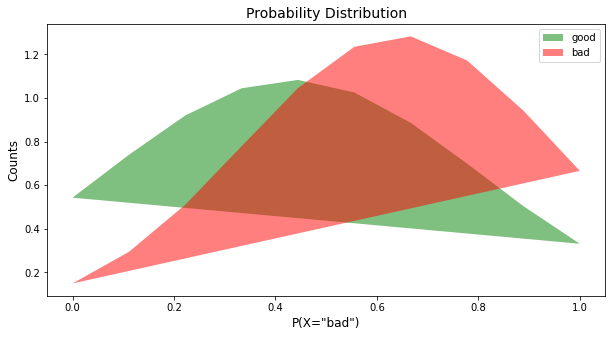

In [90]:
x = np.linspace(0, 1, num=100)
good_pdf = pdf(x,output_ID['uncert'].std(),output_ID["uncert"].mean())
bad_pdf = pdf(x,output_OOD['uncert'].std(),output_OOD["uncert"].mean())
fig, ax = plt.subplots(1,1, figsize=(10,5))
plot_pdf(good_pdf, bad_pdf, ax)

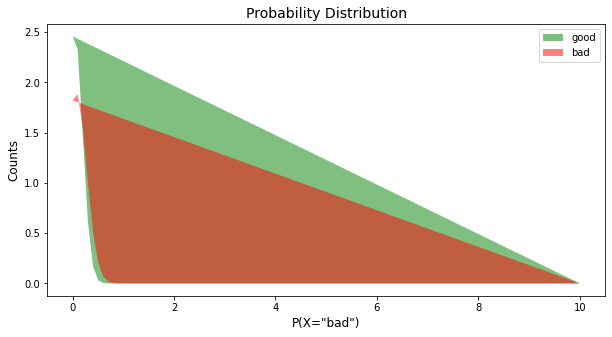

In [97]:
x = np.linspace(0, 10, num=100)
good_pdf = pdf(x,output_ID['entropy'].std(),output_ID["entropy"].mean())
bad_pdf = pdf(x,output_OOD['entropy'].std(),output_OOD["entropy"].mean())
fig, ax = plt.subplots(1,1, figsize=(10,5))
plot_pdf(good_pdf, bad_pdf, ax)

In [82]:
def plot_roc(good_pdf, bad_pdf, ax):
    #Total
    total_bad = np.sum(bad_pdf)
    total_good = np.sum(good_pdf)
    #Cumulative sum
    cum_TP = 0
    cum_FP = 0
    #TPR and FPR list initialization
    TPR_list=[]
    FPR_list=[]
    #Iteratre through all values of x
    for i in range(len(x)):
        #We are only interested in non-zero values of bad
        if bad_pdf[i]>0:
            cum_TP+=bad_pdf[len(x)-1-i]
            cum_FP+=good_pdf[len(x)-1-i]
        FPR=cum_FP/total_good
        TPR=cum_TP/total_bad
        TPR_list.append(TPR)
        FPR_list.append(FPR)
    #Calculating AUC, taking the 100 timesteps into account
    auc=np.sum(TPR_list)/500
    #Plotting final ROC curve
    ax.plot(FPR_list, TPR_list)
    ax.plot(x,x, "--")
    ax.set_xlim([0,1])
    ax.set_ylim([0,1])
    ax.set_title("ROC Curve", fontsize=14)
    ax.set_ylabel('TPR', fontsize=12)
    ax.set_xlabel('FPR', fontsize=12)
    ax.grid()
    ax.legend(["AUC=%.3f"%auc])

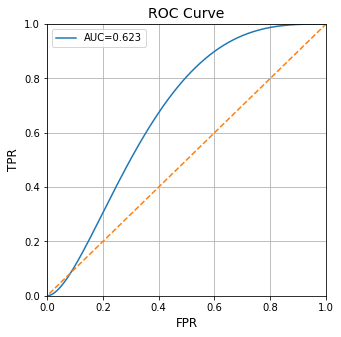

In [83]:
fig, ax = plt.subplots(1,1, figsize=(5,5))
plot_roc(good_pdf, bad_pdf, ax)

In [40]:
x = np.array([1.,2.,3.,4.,5.,6.])
tf.nn.softmax(x)

<tf.Tensor: shape=(6,), dtype=float64, numpy=
array([0.00426978, 0.01160646, 0.03154963, 0.08576079, 0.23312201,
       0.63369132])>

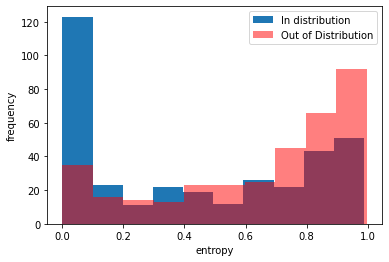

In [137]:
def buildOutlierPlot(ID,OOD,threshold=None):
    _ = plt.hist(ID['uncert'], bins=10)  # arguments are passed to np.histogram
    _ = plt.hist(OOD['uncert'], bins=10,color="red",alpha=0.5)  # arguments are passed to np.histogram
    # plt.title("Histogram with 'auto' bins")
    plt.legend(["In distribution","Out of Distribution"])
    plt.xlabel("entropy")
    plt.ylabel("frequency")
    plt.show()
    if threshold:
        print("OOD accepted with avg ID entropy threshold of ",threshold, ": ", len(OOD.loc[(OOD['uncert'] <= threshold)]), "out of ", len(OOD))
        print("ID accepted with avg ID entropy threshold of ",threshold, ": ", len(ID.loc[(ID['uncert'] <= threshold)]), "out of ", len(ID), "with acc of ", len(ID.loc[(ID['uncert'] <= threshold) & ID['correct'] == True])/len(ID.loc[(ID['uncert'] <= threshold)]))
        Correct = ID.loc[(ID['correct'] == True)]
        Incorrect = ID.loc[(ID['correct'] == False)]
        print("overall acc on ID:",len(Correct)/len(ID))

# buildOutlierPlot(outputs_test, outputs100, 0.4392441)

buildOutlierPlot(output_ID_edl, output_OOD_edl_100, None)

In [100]:
# num_right = len(right_score)
# num_wrong = len(wrong_score)
# print(num_right)
# print(num_wrong)
# print('Error Rate {:.2f}'.format(100 * num_wrong / (num_wrong + num_right)))

64
64
Error Rate 50.00


In [79]:
### MA-EBM OOD detection

import numpy as np
from scipy.special import gammaln, digamma
import tensorflow as tf

def dirichlet_prior_network_uncertainty(logits, epsilon=1e-10, alpha_correction=True):
    """
    :param logits:
    :param epsilon:
    :return:
    """
    logits = np.asarray(logits, dtype=np.float64)
    alphas = np.exp(logits)

    alphas = np.clip(alphas, 0, np.finfo(np.dtype("float32")).max)

    if alpha_correction:
        alphas = alphas + 1

    alpha0 = np.sum(alphas, axis=1, keepdims=True)
    probs = alphas / alpha0

    conf = np.max(probs, axis=1)

    entropy_of_exp = -np.sum(probs * np.log(probs + epsilon), axis=1)
    expected_entropy = -np.sum(
        (alphas / alpha0) * (digamma(alphas + 1) - digamma(alpha0 + 1.0)), axis=1
    )

    mutual_info = entropy_of_exp - expected_entropy

    epkl = np.squeeze((alphas.shape[1] - 1.0) / alpha0)

    dentropy = (
        np.sum(
            gammaln(alphas) - (alphas - 1.0) * (digamma(alphas) - digamma(alpha0)),
            axis=1,
            keepdims=True,
        )
        - gammaln(alpha0)
    )

    uncertainty = {
        "confidence_alea_uncert.": conf,
        "entropy_of_expected": -entropy_of_exp,
        "expected_entropy": -expected_entropy,
        "mutual_information": -mutual_info,
        "EPKL": -epkl,
        "differential_entropy": -np.squeeze(dentropy),
    }
    results = {}
    
    for k,v in uncertainty.items():
            results[k] =v.mean()
    # k: torch.from_numpy(v).float() for k, v in uncertainty.items()
    results["p(x)"] = tf.math.reduce_logsumexp(tf.cast(logits,tf.float32)).numpy()
    results["max p(y|x)"] = np.amax(tf.nn.softmax(tf.cast(logits,tf.float32)))

    return results
# dirichlet_prior_network_uncertainty([[1,1,1,1,1,1,1,1,1,1]])
logits = [[1,1,1,1,1,1,1,1,1,1]]
dir_uncert = dirichlet_prior_network_uncertainty(logits)
print(dir_uncert)

{'confidence_alea_uncert.': 0.09999999999999999, 'entropy_of_expected': -2.302585091994046, 'expected_entropy': -2.1874864443604523, 'mutual_information': -0.11509864763359356, 'EPKL': -0.2420472792329956, 'differential_entropy': 15.84162062462957, 'p(x)': 3.3025851, 'max p(y|x)': 0.1}


In [80]:
#next, do the outlier comparasion test for the energy model and make a graph for each of these values.
import math
num_classes=10
def getPredictions_energy(model, input_set, stopping_point = None):
    # stopping_point = None
    num_outputs = len(model.outputs) # the number of output layers for the purpose of providing labels
    #     train_ds, test_ds, validation_ds = (dataset)
    Results=[]
    Pred=[]
    Labels =[]
    Uncert = []
    Outputs = pd.DataFrame()
    Dir_U = []
    pAcc=[]
    for i, (x,y) in enumerate(input_set):
        if stopping_point and i > stopping_point:
            break
        print("prediction: {} of {}".format(i,len(test_ds)),end='\r')
        predictions = model.predict(x)
        for j, prediction in enumerate(predictions):
            dir_uncert = dirichlet_prior_network_uncertainty(np.array([prediction]))
            Dir_U.append(dir_uncert)
            Results.append(np.argmax(prediction))
            Labels.append(np.argmax(y[j]))
    _uncert = np.array(Uncert)
    print(_uncert)
    print("avg entropy",_uncert.mean())
    energy_uncert = pd.DataFrame(Dir_U)
    # print(energy_uncert)
    df = pd.DataFrame({"x":Results,"y":Labels})
    df = pd.concat([df,energy_uncert],axis=1,join="inner")
    conditions = [df['x'] == df['y'],df['x'] != df['y']]
    choices = [1, 0]
    df['correct'] = np.select(conditions, choices, default=None)
    return df

# Correct = outputs.loc[(outputs['correct'] == True)].groupby("correct")["uncert"].mean().iloc[0]
# Incorrect = outputs.loc[(outputs['correct'] == False)].groupby("correct")["uncert"].mean().iloc[0]
# print("Correct", Correct, "incorrect", Incorrect)
# print("overallAcc", len(outputs.loc[(outputs['correct'] == True)])/len(outputs))



In [ ]:

outputs_test = getPredictions_energy(model,test_ds)
print(outputs_test)
        
outputs100 = getPredictions_energy(model,test_ds100)
print(outputs100)


[]ediction: 311 of 312
avg entropy nan


C:\Users\Sanity\AppData\Local\conda\conda\envs\py36\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: Mean of empty slice.
C:\Users\Sanity\AppData\Local\conda\conda\envs\py36\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


      x  y  confidence_alea_uncert.  entropy_of_expected  expected_entropy  \
0     8  3                 0.814705            -0.482196         -0.482049   
1     8  8                 0.999999            -0.000019         -0.000019   
2     0  8                 0.525802            -0.693304         -0.693240   
3     0  0                 0.999313            -0.005692         -0.005692   
4     6  6                 0.990790            -0.055615         -0.055382   
...  .. ..                      ...                  ...               ...   
9979  5  3                 0.718007            -0.610635         -0.609681   
9980  0  0                 0.964415            -0.154899         -0.154828   
9981  7  4                 0.998228            -0.014470         -0.014319   
9982  4  2                 0.999989            -0.000162         -0.000158   
9983  1  0                 1.000000            -0.000004         -0.000004   

      mutual_information          EPKL  differential_entropy   

In [77]:
def buildOutlierPlot_energy(ID,OOD,threshold=None):
    for k in ['confidence_alea_uncert.','entropy_of_expected','expected_entropy','mutual_information','EPKL','differential_entropy']:
        _ = plt.hist(ID[k].tolist(), bins=10)  # arguments are passed to np.histogram
        _ = plt.hist(OOD[k].tolist(), bins=10,color="red",alpha=0.5)  # arguments are passed to np.histogram
        # plt.title("Histogram with 'auto' bins")
        plt.title(k)
        plt.legend(["In distribution","Out of Distribution"])
        plt.xlabel("entropy")
        plt.ylabel("frequency")
        plt.show()
        # print("OOD accepted with avg ID entropy threshold of ",threshold, ": ", len(OOD.loc[(OOD['uncert'] <= threshold)]), "out of ", len(OOD))
        # print("ID accepted with avg ID entropy threshold of ",threshold, ": ", len(ID.loc[(ID['uncert'] <= threshold)]), "out of ", len(ID), "with acc of ", len(ID.loc[(ID['uncert'] <= threshold) & ID['correct'] == True])/len(ID.loc[(ID['uncert'] <= threshold)]))
        # Correct = ID.loc[(ID['correct'] == True)]
        # Incorrect = ID.loc[(ID['correct'] == False)]
        # print("overall acc on ID:",len(Correct)/len(ID))
    
# buildOutlierPlot_energy(outputs_test, outputs100, None)

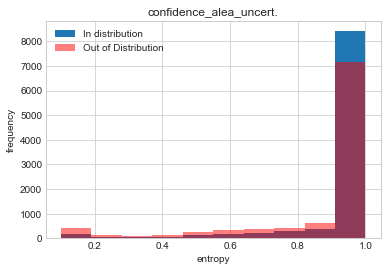

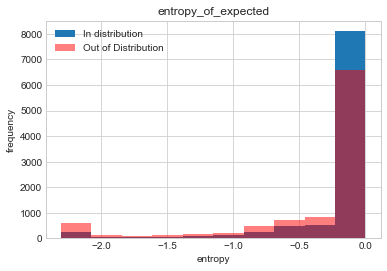

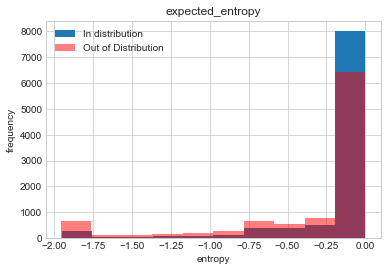

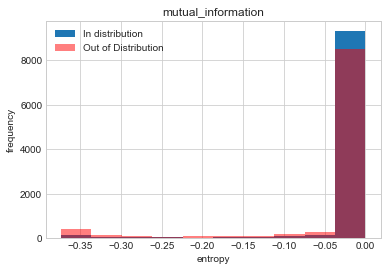

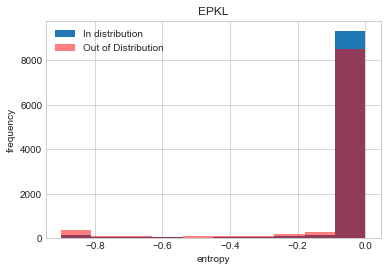

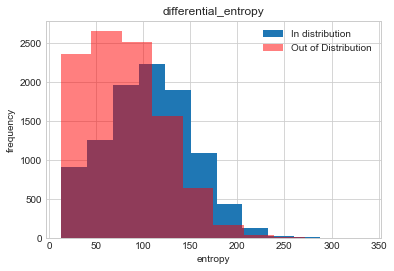

In [78]:
buildOutlierPlot_energy(outputs_test,outputs100)

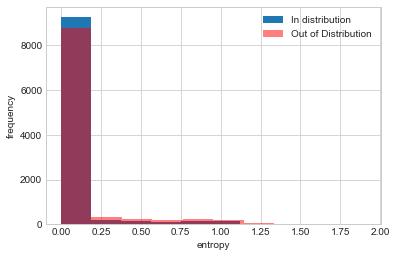

OOD accepted with avg ID entropy threshold of  0.051234607 :  8231 out of  9984
ID accepted with avg ID entropy threshold of  0.051234607 :  8968 out of  9984 with acc of  0.6952497769848349
overall acc on ID: 0.65625


In [172]:
buildOutlierPlot(outputs_test, outputs100, 0.051234607)

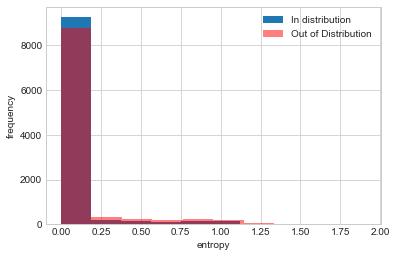

OOD accepted with avg ID entropy threshold of  0.4392441 :  9156 out of  9984
ID accepted with avg ID entropy threshold of  0.4392441 :  9494 out of  9984 with acc of  0.6754792500526648
overall acc on ID: 0.65625


(50000, 32, 32, 3)
<BatchDataset element_spec=(TensorSpec(shape=(32, 32, 32, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(32, 100), dtype=tf.float32, name=None))>


In [130]:
import math
num_classes=10
def getPredictions(model, input_set, stopping_point=None):
    # stopping_point = None
    num_outputs = len(model.outputs) # the number of output layers for the purpose of providing labels
    #     train_ds, test_ds, validation_ds = (dataset)
    Results=[]
    Pred=[]
    Labels =[]
    Uncert = []
    Outputs = pd.DataFrame()
    pAcc=[]
    for i, (x,y) in enumerate(input_set):
        if stopping_point and i > stopping_point:
            break
        print("prediction: {} of {}".format(i,len(test_ds)),end='\r')
        predictions = model.predict(x)
        for j, prediction in enumerate(predictions):
            evidence =exp_evidence(prediction)
            alpha = evidence +1
            S = sum(alpha)
            E = alpha - 1
            Mass = alpha / S
            u = num_classes / S
            Uncert.append(u.numpy().mean())
            Results.append(np.argmax(prediction))
            Labels.append(np.argmax(y[j]))
    _uncert = np.array(Uncert)
    # print(_uncert)
    print("avg entropy",_uncert.mean())
    df = pd.DataFrame({"x":Results,"y":Labels,"uncert":Uncert})
    conditions = [df['x'] == df['y'],df['x'] != df['y']]
    choices = [1, 0]
    df['correct'] = np.select(conditions, choices, default=None)
    return df

# Correct = outputs.loc[(outputs['correct'] == True)].groupby("correct")["uncert"].mean().iloc[0]
# Incorrect = outputs.loc[(outputs['correct'] == False)].groupby("correct")["uncert"].mean().iloc[0]
# print("Correct", Correct, "incorrect", Incorrect)
# print("overallAcc", len(outputs.loc[(outputs['correct'] == True)])/len(outputs))



In [110]:
outputs = getPredictions(model,test_ds)
print(outputs)
# avg entropy 0.43924412

avg entropy 4.39244132
      x  y    uncert correct
0     3  3  9.289042       1
1     1  8  5.010212       0
2     1  8  8.567102       0
3     0  0  9.048504       1
4     4  6  0.930254       0
...  .. ..       ...     ...
9979  3  3  8.626763       1
9980  8  0  9.663918       0
9981  4  4  2.363454       1
9982  6  2  8.410823       0
9983  1  0  5.350562       0

[9984 rows x 4 columns]


      x  y    uncert correct
4     4  6  0.930254       0
5     5  6  3.623051       0
6     9  1  1.296380       0
7     6  6  2.699459       1
11    9  9  0.004538       1
...  .. ..       ...     ...
9975  7  7  0.004538       1
9976  5  5  0.979602       1
9977  5  5  0.282922       1
9978  4  7  0.796550       0
9981  4  4  2.363454       1

[5065 rows x 4 columns]
      x  y    uncert correct
0     3  3  9.289042       1
3     0  0  9.048504       1
7     6  6  2.699459       1
8     3  3  7.678715       1
9     1  1  6.884835       1
...  .. ..       ...     ...
9975  7  7  0.004538       1
9976  5  5  0.979602       1
9977  5  5  0.282922       1
9979  3  3  8.626763       1
9981  4  4  2.363454       1

[6483 rows x 4 columns]


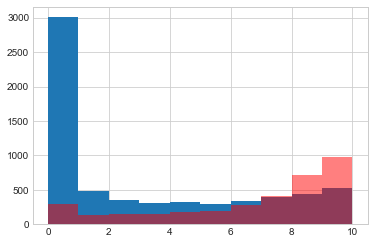

In [117]:
threshold = 4.39244132
accepted = outputs.loc[(outputs['uncert'] <= threshold)]
print(accepted)

import matplotlib.pyplot as plt
Correct = outputs.loc[(outputs['correct'] == True)]
Incorrect = outputs.loc[(outputs['correct'] == False)]
print(Correct)
_ = plt.hist(Correct['uncert'].tolist(), bins=10)  # arguments are passed to np.histogram
_ = plt.hist(Incorrect['uncert'].tolist(), bins=10,color="red",alpha=0.5)  # arguments are passed to np.histogram
# plt.title("Histogram with 'auto' bins")
plt.show()

In [130]:

outputs100 = getPredictions(model,test_ds100)
print(outputs100)

[0.23711371 0.67648697 0.85404116 ... 0.7878681  0.66152674 0.10553702]
avg entropy 0.66300267
      x   y    uncert correct
0     0  49  0.237114       0
1     4  33  0.676487       0
2     4  72  0.854041       0
3     1  51  0.115120       0
4     1  71  0.842340       0
...  ..  ..       ...     ...
9979  3  27  0.366997       0
9980  8  30  0.636400       0
9981  9  52  0.787868       0
9982  6  74  0.661527       0
9983  6  29  0.105537       0

[9984 rows x 4 columns]


      x   y    uncert correct
0     0  49  0.237114       0
3     1  51  0.115120       0
6     4  15  0.370688       0
9     7   0  0.156786       0
10    3  71  0.411594       0
...  ..  ..       ...     ...
9970  6  18  0.008494       0
9972  8  26  0.239801       0
9974  8  11  0.308005       0
9979  3  27  0.366997       0
9983  6  29  0.105537       0

[2403 rows x 4 columns]
      x  y    uncert correct
200   6  6  0.887254       1
267   1  1  0.786784       1
268   6  6  0.806364       1
476   8  8  0.453028       1
648   7  7  0.866996       1
...  .. ..       ...     ...
9524  1  1  0.681051       1
9853  4  4  0.495359       1
9857  9  9  0.902897       1
9874  7  7  0.935731       1
9945  4  4  0.835873       1

[84 rows x 4 columns]


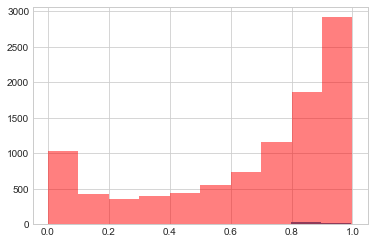

In [131]:
threshold = 0.4392441
accepted = outputs100.loc[(outputs100['uncert'] <= threshold)]
print(accepted)

import matplotlib.pyplot as plt
Correct = outputs100.loc[(outputs100['correct'] == True)]
Incorrect = outputs100.loc[(outputs100['correct'] == False)]
print(Correct)
_ = plt.hist(Correct['uncert'].tolist(), bins=10)  # arguments are passed to np.histogram
_ = plt.hist(Incorrect['uncert'].tolist(), bins=10,color="red",alpha=0.5)  # arguments are passed to np.histogram
# plt.title("Histogram with 'auto' bins")
plt.show()

      x  y    uncert correct
200   6  6  0.887254       1
267   1  1  0.786784       1
268   6  6  0.806364       1
476   8  8  0.453028       1
648   7  7  0.866996       1
...  .. ..       ...     ...
9524  1  1  0.681051       1
9853  4  4  0.495359       1
9857  9  9  0.902897       1
9874  7  7  0.935731       1
9945  4  4  0.835873       1

[84 rows x 4 columns]


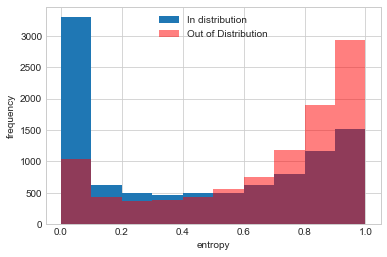

OOD accepted with avg ID entropy threshold of  0.4392441 :  2403 out of  9984
ID accepted with avg ID entropy threshold of  0.4392441 :  5065 out of  9984 with acc of  0.8452122408687068


In [140]:
def buildOutlierPlot(ID,OOD,threshold):
    _ = plt.hist(ID['uncert'].tolist(), bins=10)  # arguments are passed to np.histogram
    _ = plt.hist(OOD['uncert'].tolist(), bins=10,color="red",alpha=0.5)  # arguments are passed to np.histogram
    # plt.title("Histogram with 'auto' bins")
    plt.legend(["In distribution","Out of Distribution"])
    plt.xlabel("entropy")
    plt.ylabel("frequency")
    plt.show()
    print("OOD accepted with avg ID entropy threshold of ",threshold, ": ", len(OOD.loc[(OOD['uncert'] <= threshold)]), "out of ", len(OOD))
    print("ID accepted with avg ID entropy threshold of ",threshold, ": ", len(ID.loc[(ID['uncert'] <= threshold)]), "out of ", len(ID), "with acc of ", len(ID.loc[(ID['uncert'] <= threshold) & ID['correct'] == True])/len(ID.loc[(ID['uncert'] <= threshold)]))
    Correct = ID.loc[(ID['correct'] == True)]
    Incorrect = ID.loc[(ID['correct'] == False)]
    print("overall acc on ID:",len(Correct)/len(ID))
    
buildOutlierPlot(outputs_test, outputs100, 0.4392441)

In [142]:
Correct = outputs_test.loc[(outputs_test['correct'] == True)]
Incorrect = outputs_test.loc[(outputs_test['correct'] == False)]
print(len(Correct)/len(outputs_test))

0.6493389423076923


In [152]:
def entropyMetric_old():
    def entropy(p, y_hat):
        #METRIC OF THE mean of uncertainity
        val = y_hat * tf.math.log(y_hat)/tf.math.log(tf.constant(2, dtype=y_hat.dtype))
        sumEntropies =  tf.reduce_sum(tf.boolean_mask(val,tf.math.is_finite(val)))
        return -sumEntropies
    return entropy

loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
model = keras.models.load_model("./models/cifaroutlier_blank.hdf5")
model.compile(optimizer='adam',
              loss=loss,
              metrics=['accuracy',entropyMetric_old()])

history = model.fit(train_ds, epochs=10)

Epoch 1/10
1406/1406 [==============================] - 7s 4ms/step - loss: 1.7714 - accuracy: 0.3800 - entropy: -269.5092
Epoch 2/10
1406/1406 [==============================] - 6s 4ms/step - loss: 1.3332 - accuracy: 0.5236 - entropy: -547.2267
Epoch 3/10
1406/1406 [==============================] - 6s 4ms/step - loss: 1.1859 - accuracy: 0.5852 - entropy: -793.7892
Epoch 4/10
1406/1406 [==============================] - 6s 4ms/step - loss: 1.0911 - accuracy: 0.6173 - entropy: -1051.1556
Epoch 5/10
1406/1406 [==============================] - 6s 5ms/step - loss: 1.0100 - accuracy: 0.6464 - entropy: -1337.5408
Epoch 6/10
1406/1406 [==============================] - 7s 5ms/step - loss: 0.9382 - accuracy: 0.6712 - entropy: -1744.2469
Epoch 7/10
1406/1406 [==============================] - 6s 4ms/step - loss: 0.8893 - accuracy: 0.6900 - entropy: -2221.8240
Epoch 8/10
1406/1406 [==============================] - 6s 4ms/step - loss: 0.8389 - accuracy: 0.7068 - entropy: -2834.1406
Epoch 9/10


In [155]:
import math
num_classes=10
def getPredictions(model, input_set):
    stopping_point = None
    num_outputs = len(model.outputs) # the number of output layers for the purpose of providing labels
    #     train_ds, test_ds, validation_ds = (dataset)
    Results=[]
    Pred=[]
    Labels =[]
    Uncert = []
    Outputs = pd.DataFrame()
    pAcc=[]
    for i, (x,y) in enumerate(input_set):
        if stopping_point and i > stopping_point:
            break
        print("prediction: {} of {}".format(i,len(test_ds)),end='\r')
        predictions = model.predict(x)
        for j, prediction in enumerate(predictions):
            y_hat =tf.nn.softmax(prediction)
            val = y_hat * tf.math.log(y_hat)/tf.math.log(tf.constant(2, dtype=y_hat.dtype))
            u =  -tf.reduce_sum(tf.boolean_mask(val,tf.math.is_finite(val)))
            Uncert.append(u.numpy().mean())
            Results.append(np.argmax(prediction))
            Labels.append(np.argmax(y[j]))
    _uncert = np.array(Uncert)
    print(_uncert)
    print("avg entropy",_uncert.mean())
    df = pd.DataFrame({"x":Results,"y":Labels,"uncert":Uncert})
    conditions = [df['x'] == df['y'],df['x'] != df['y']]
    choices = [1, 0]
    df['correct'] = np.select(conditions, choices, default=None)
    return df

outputs_test2 = getPredictions(model,test_ds)
print(outputs_test2)
# Correct = outputs.loc[(outputs['correct'] == True)].groupby("correct")["uncert"].mean().iloc[0]
# Incorrect = outputs.loc[(outputs['correct'] == False)].groupby("correct")["uncert"].mean().iloc[0]
# print("Correct", Correct, "incorrect", Incorrect)
# print("overallAcc", len(outputs.loc[(outputs['correct'] == True)])/len(outputs))
model.evaluate(test_ds)


[2.9127266  0.28847754 1.7646978  ... 1.5443833  2.1113863  0.4810803 ]
avg entropy 1.0540112
      x  y    uncert correct
0     8  3  2.912727       0
1     8  8  0.288478       1
2     0  8  1.764698       0
3     0  0  0.412173       1
4     6  6  1.835032       1
...  .. ..       ...     ...
9979  3  3  0.222059       1
9980  0  0  0.102112       1
9981  7  4  1.544383       0
9982  3  2  2.111386       0
9983  1  0  0.481080       0

[9984 rows x 4 columns]


In [156]:
outputs100_2 = getPredictions(model,test_ds100)
print(outputs100_2)

[0.7781605 2.2761638 1.5880288 ... 0.7205749 2.28415   1.5985643]
avg entropy 1.5279474
      x   y    uncert correct
0     2  49  0.778161       0
1     4  33  2.276164       0
2     0  72  1.588029       0
3     9  51  1.273938       0
4     8  71  2.651380       0
...  ..  ..       ...     ...
9979  2  27  0.562674       0
9980  0  30  1.932048       0
9981  7  52  0.720575       0
9982  5  74  2.284150       0
9983  2  29  1.598564       0

[9984 rows x 4 columns]


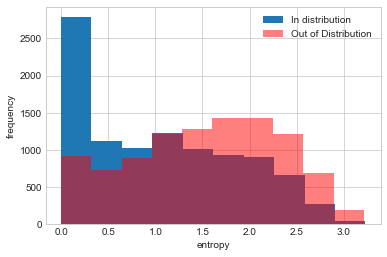

OOD accepted with avg ID entropy threshold of  1.5279474 :  4726 out of  9984
ID accepted with avg ID entropy threshold of  1.5279474 :  6876 out of  9984 with acc of  0.7232402559627691
overall acc on ID: 0.6126802884615384


In [161]:
def buildOutlierPlot(ID,OOD,threshold):
    _ = plt.hist(ID['uncert'].tolist(), bins=10)  # arguments are passed to np.histogram
    _ = plt.hist(OOD['uncert'].tolist(), bins=10,color="red",alpha=0.5)  # arguments are passed to np.histogram
    # plt.title("Histogram with 'auto' bins")
    plt.legend(["In distribution","Out of Distribution"])
    plt.xlabel("entropy")
    plt.ylabel("frequency")
    plt.show()
    print("OOD accepted with avg ID entropy threshold of ",threshold, ": ", len(OOD.loc[(OOD['uncert'] <= threshold)]), "out of ", len(OOD))
    print("ID accepted with avg ID entropy threshold of ",threshold, ": ", len(ID.loc[(ID['uncert'] <= threshold)]), "out of ", len(ID), "with acc of ", len(ID.loc[(ID['uncert'] <= threshold) & ID['correct'] == True])/len(ID.loc[(ID['uncert'] <= threshold)]))
    Correct = ID.loc[(ID['correct'] == True)]
    Incorrect = ID.loc[(ID['correct'] == False)]
    print("overall acc on ID:",len(Correct)/len(ID))
    
buildOutlierPlot(outputs_test2, outputs100_2, 1.5279474)

In [165]:
def MAEBM(annealing):
    def loss(labels, outputs):
        # tf.print(outputs)
        evidence = tf.exp(outputs) #activation function
        # tf.print(evidence)
        alpha = evidence + 1
        S = tf.reduce_sum(alpha)
        # tf.print(S)
        alpha_0 = tf.fill(alpha.shape,S)
        UCE_loss = tf.reduce_mean(labels * (tf.compat.v1.digamma(alpha_0) - tf.compat.v1.digamma(alpha)))
        # print("loss_1",UCE_loss)
        
        
        UCE_loss  +=  0.0001  * (tf.reduce_sum(tf.compat.v1.lgamma(alpha)) - tf.compat.v1.lgamma(S) -
                (len(alpha) - S) * tf.compat.v1.digamma(S) -
                ((alpha - 1.0) * tf.reduce_sum(tf.compat.v1.digamma(alpha))))
        # tf.print(UCE_loss)
        return UCE_loss
    return loss 
def entropyMetric():
    def entropy(p, logits):
        #METRIC OF THE mean of uncertainity
        evidence =exp_evidence(logits)
        alpha = evidence +1
        S = tf.reduce_sum(alpha)
        Mass = alpha / S
        u = num_classes / S
        return (tf.reduce_mean(u)) # Note the `axis=-1`
    return entropy

lambda_callback = lambda_update(100)
loss = MAEBM(lambda_callback)
model = keras.models.load_model("./models/cifaroutlier_blank.hdf5")
model.compile(optimizer='adam',
              loss=loss,
              metrics=['accuracy',entropyMetric()])

history = model.fit(train_ds, epochs=10,callbacks=[lambda_callback])


annealing coef updated to: 0
Epoch 1/10
 753/1406 [===============>..............] - ETA: 3s - loss: nan - accuracy: 0.1011 - entropy: nan

KeyboardInterrupt: 